<a href="https://colab.research.google.com/github/mtablado/uoc2022_tfm/blob/main/MRI-loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import os
import matplotlib
import random
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import glob
import nibabel as nib #reading MR images

from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
# Make sure we are at the expected directory
%cd /content/drive/My Drive/tfm/dataset/

ff = glob.glob('./IXI-T1/*.nii.gz')

image = nib.load(ff[0])
image = image.get_fdata()



/content/drive/.shortcut-targets-by-id/1yKlrvb9Cp3amASiDUettfP3V1KJuzGDe/tfm/dataset


In [10]:
print(image.shape)
print(type(image))

(256, 256, 130)
<class 'numpy.ndarray'>


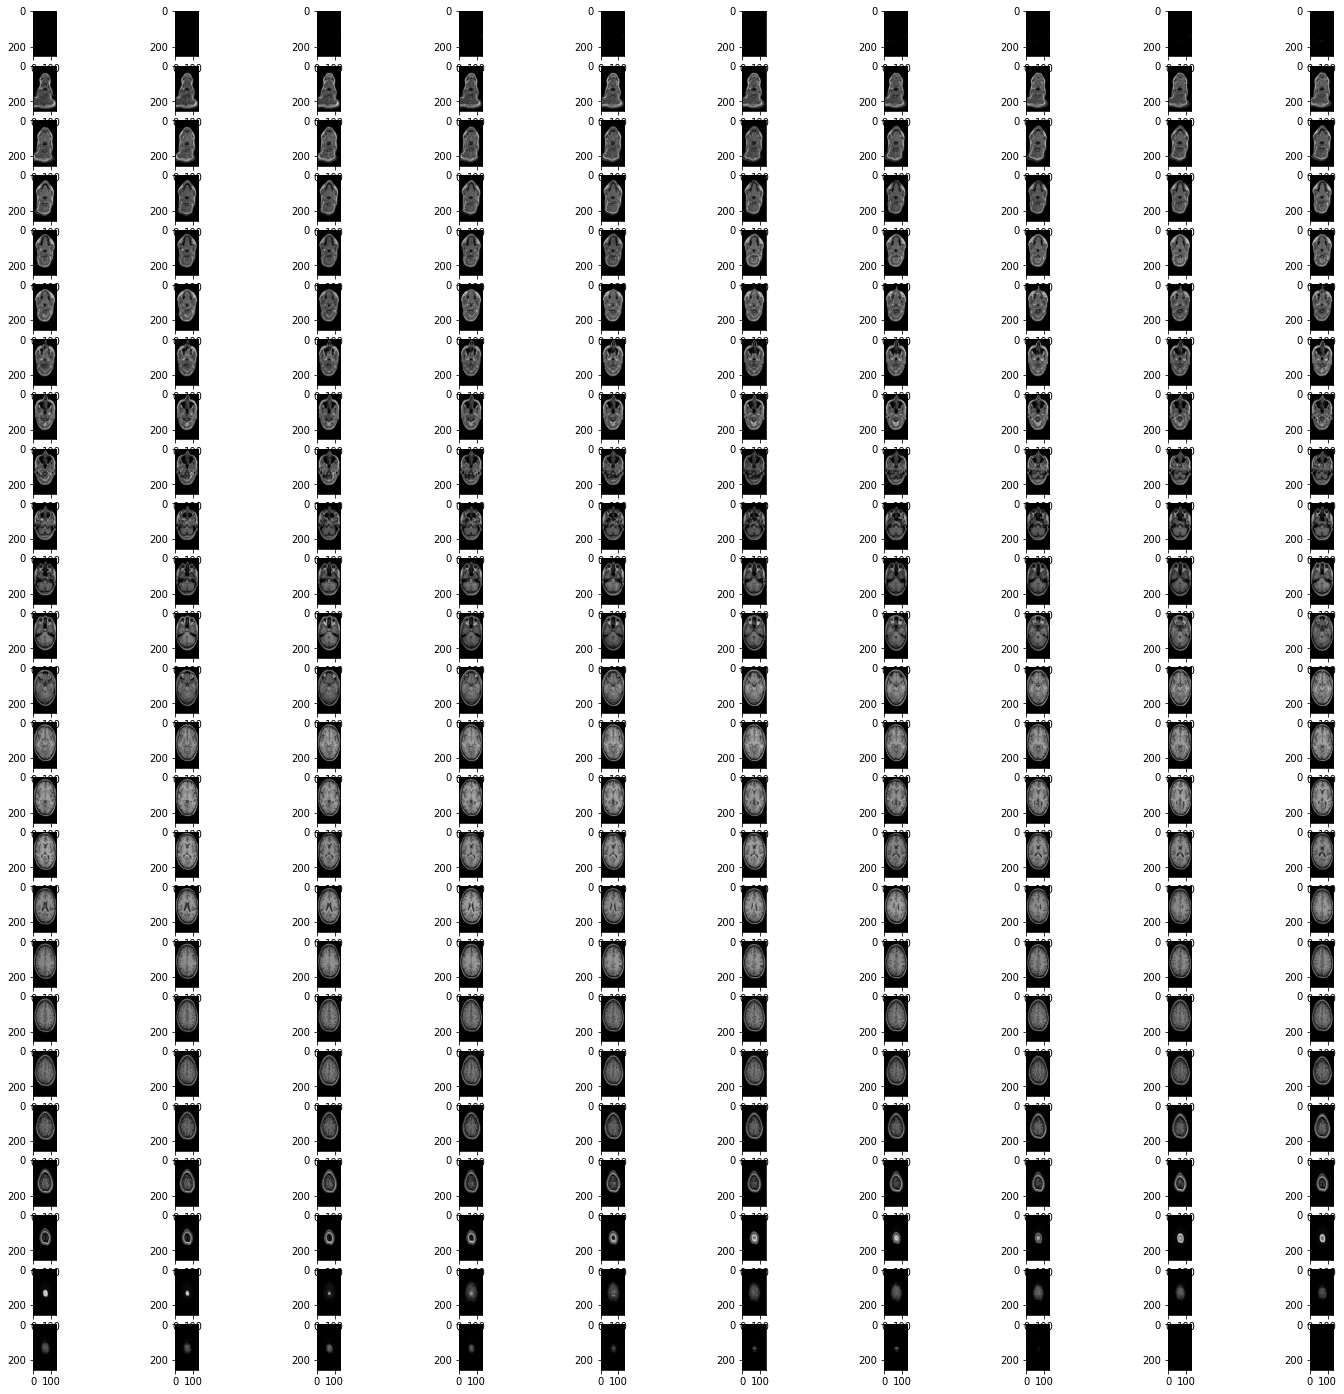

In [12]:
f, big_axes = plt.subplots(25,10, figsize=(25,25))

for i in range(0,25):
  for j in range(0,10):
    slice_position = ((i - 1) * 10) + j
    big_axes[i,j].imshow(image[:,slice_position,:], cmap='gray')




In [13]:
SLICES_DIR = 'slices-160-190'

def save_slices(filename :str, images :list):
  """
  Saves the slices given as an array on 3 different directories after being
  randomly shuffled to avoid overfitting.
  The 3 directoires at drive will be 'training', 'test', 'validation'
  Arguments:
    images: array with MRI brain slices
  """
  # Shuffle images to be stored randomly on training, validation and test dirs
  random.shuffle(images)

  filename = re.sub("\.nii\.gz", "", filename)
  total = len(images)

  for i, image in enumerate(images):
    name = filename + '_' + str(i) + '.png'
    if (i > 0.9 * total):
      name = SLICES_DIR + '/test/t1/' + name
    else:
      name = SLICES_DIR + '/training/t1/' + name
    
    print("Saving file " + name)
    matplotlib.image.imsave(name, image, cmap='gray')

def load_slices(file :str) -> any:
  a = nib.load(file)
  a = a.get_fdata()
  a = a[:,160:190,:]
  return a

def extract_slices(file_list :list) -> np.ndarray:
  """ 
  It extracts the slices of the MRI images stored in the given files 
  Arguments:
      ff: list of nifti files
  Returns:
      An array with the selected slices from the different files  
  """
  
  for f in range(len(file_list)):
  #for f in range(len([0, 1])):
    filename = os.path.basename(file_list[f])
    images = []
    a = load_slices('./IXI-T1/' + filename)
    for i in range(a.shape[1]):
      images.append((a[:,i,:]))
    save_slices(filename, images)
  return images

try:
  os.mkdir('/content/drive/MyDrive/tfm/dataset/' + SLICES_DIR + '/training/t1', mode=644)
  os.mkdir('/content/drive/MyDrive/tfm/dataset/' + SLICES_DIR + '/test/t1', mode=644)
except:
  print('directories already exist')

# Extract slices from files
images = extract_slices(ff)

image = images[1]

print (image.shape)

directories already exist
Saving file slices-160-190/training/IXI023-Guys-0699-T1_0.png


FileNotFoundError: ignored

In [ ]:
drive.flush_and_unmount()

In [ ]:
print(image[100,50])

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
#img = image[:,:,100]
plt.imshow(image, cmap='gray')

